ЛАБОРАТОРНАЯ РАБОТА 5. ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ

Цели и задачи

Цель лабораторной работы: изучение принципов построения информационных систем с использованием линейных методов машинного обучения.
Основные задачи:
–	освоение технологии внедрения алгоритмов линейной классификации в приложения;
–	изучение основных приемов рабты с разреженными матрицами в ходе машинного обучения;
–	освоение 	техники 	построения, 	обучения 	и 	оценки 	модели
логистической регресии;
–	освоение приемов работы с синтезированными признаками, масштабированием и настройкой гипперпараметров.

Оборудование и материалы

Для выполнения лабораторной работы рекомендуется использовать персональный компьютер со следующими программными средствами разработки (выбрать один или несколько програмных продуктов для практической реализации задач лабораторной работы): MS Visual Studio 2013 и выше; среда разработки Java, интерпретатор Python (Jupyter Notebook).

Методика и порядок выполнения работы

Постановка задачи.
В рамках учебной задачи резберем проблему «Catch Me If You Can:
Intruder Detection through Webpage Session (https://inclass.kaggle.com/c/catchme-if-you-can-intruder-detection-through-webpage-session-tracking).
Решается задача идентификации взломщика по его поведению в сети Интернет. Например, взломщик почтового ящика будет вести себя не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, как это делал хозяин, он будет по-другому ставить флажки сообщениям и даже посвоему двигать мышкой. Тогда такого злоумышленника можно идентифицировать и «выкинуть» из почтового ящика, предложив хозяину войти по SMS-коду. Похожие механизмы разрабатываются, например, в Google Analytics и описываются в научных статьях, найти можно многое по фразам «Traversal Pattern Mining» и «Sequential Pattern Mining».
В учебной задаче рассмотрим похожую задачу: алгоритм будет анализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, и определять, Элис это или взломщик (ктото другой). В качестве метрики в этом соревновании используется ROC AUC.
В обучающей выборке train_sessions.csv представлены следующие признаки:
–	site_i – это индексы посещенных сайтов (расшифровка дана в pickleфайле со словарем site_dic.pkl);
–	time_j – время посещения сайтов site_j;
target – целевой признак; факт того, что сессия принадлжит Элис (то есть
что именно Элис ходила по всем этим сайтам).
	Задача 	– 	сделать 	прогнозы 	для 	сессий 	в 	тестовой 	выборке
(test_sessions.csv), определить, принадлежат ли они Элис.
Не обязательно ограничиваться только предложенной выборкой train_sessions.csv – в train.zip даны исходные данные о посещенных пользователями веб-страницах, по которым можно сформировать свою обучающую выборку.
Переходим к решению:
1.	Подключем необходимые библиотеки:


In [ ]:
from __future__ import division, print_function
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

2.	Проведем первичное обследование набора данных. Выполним загрузку данных (рис. 5.2).

In [ ]:
train_df = pd.read_csv('train_sessions.csv', index_col='session_id')
test_df = pd.read_csv('train_sessions.csv', index_col='session_id')

times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)
train_df = train_df.sort_values(by='time1')

print(train_df.shape)
print(test_df.shape)
train_df.head()

(253561, 21)
(253561, 21)


,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


В каждой строке набора данных содержатся признаки сессии:
–	site1 – индекс первого посещенного сайта в сессии;
–	time1 – время посещения первого сайта в сессии;
...
–	site10 – индекс 10-го посещенного сайта в сессии;
–	time10 – время посещения 10-го сайта в сессии;
–	target – целевая переменная, принимает значение 1 для сессий Элис и 0 для сессий других пользователей.
Сессии пользователей выделены таким образом, что они не могут быть длинее получаса или содержит более 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут.
В таблице встречаются пропущенные значения, это значит, что сессия состоит менее, чем из 10 сайтов.  
3.	Заменим пропущенные значения нулем и приведем колонки целому типу. Также загрузим словарь сайтов и посмотрим как он выглядит:
  


In [ ]:
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

with open(r"site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

sites_dict = pd.DataFrame(list(site_dict.keys()),
                          index=list(site_dict.values()),
                          columns=['site'])
print(u'всего сайтов:', sites_dict.shape[0])
sites_dict.head()

всего сайтов: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


4.	Покажем, какие сайты являются топовыми, наиболее популярными по посещаемости:

In [ ]:
top_sites = pd.Series(train_df[sites].fillna(0).values.flatten()
                     ).value_counts().sort_values(ascending=False).head(5)
print(top_sites)
sites_dict.iloc[top_sites.index]

21     123776
0      122730
23      87619
782     77055
22      58258
Name: count, dtype: int64


,site
5671,www.pacajob.com
25075,www.abmecatronique.com
7104,cbv.sfr.bench.cedexis.com
39605,cid-d6bf976dfdf5d212.users.storage.live.com
32074,mathaa.epfl.ch


5.	Основную работу будем проводить с временными параметрами сессий. Для этого создадим отдельный фрейм данных для хранения начала сессии, лклнчания сессии и ее длительности (рис. 5.5).
  


In [ ]:
# создадим отдельный датафрейм
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']

# найдем время начала и окончания сессии
time_df['min'] = train_df[times].min(axis=1)
time_df['min'] = pd.to_datetime(time_df['min'])
time_df['max'] = train_df[times].max(axis=1)
time_df['max'] = pd.to_datetime(time_df['max'])

# вычислим длительность сессии и переведем в секунды
time_df['seconds'] = \
(time_df['max'].values - \
 time_df['min'].values) / np.timedelta64(1, 's')

time_df.head()

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0


Чтобы перейти к обучению модели, необходимо подготовить данные. С самого начала выделим целевую переменную и удалим ее из обучающей выборки. Теперь и обучающая, и тестовая выборки будут иметь одинаковое количество колонок, поэтому объединим их в один общий датафрейм. Таким образом, все преобразования будут выполняться одновременно как для обучающей, так и для тестовой выборок. С одной стороны, это ведет к тому, что у обеих выборок будет одно пространство признаков (можно не волноваться, что забыли сделать преобразование какого-то признака для одной из выборок), но с другой возрастает время обработки. Для больших выборок может оказаться невозможным сделать преобразования одновременно для обеих выборок (а иногда преобразования придется разбивать на несколько этапов только для обучающей/тестовой выборки). Здесь же мы будем делать преобразования для объединенной таблицы целиком, а перед обучением или прогнозированием просто возьмем нужную ее часть.

In [ ]:
#наша целевая переменная
y_train = train_df['target']
# объединенная таблица исходных данных
full_df = pd.concat([train_df.drop('target', axis=1), test_df])
# индекс, по которому будем отделять обучающую выборку от тестовой
idx_split = train_df.shape[0]

print('y_train', y_train.shape)
print('train_df', train_df.shape)
print('full_df', full_df.shape)

y_train (253561,)
train_df (253561, 21)
full_df (507122, 21)



6.	Для первой модели будем использовать только посещенные сайты в сессии (но не будем обращать внимание на временные признаки). За таким выбором данных для модели стоит следующая идея: у Элис есть свои излюбленные сайты, и чем чаще вы видим эти сайты в сессии, тем выше вероятность, что это сессия Элис, и наоборот. Подготовим данные, из всей таблицы выберем только признаки site1, site2, ... , site10. Пропущенные значения заменены нулем. Вот как выглядят первые строки таблицы:


In [ ]:
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


Сессии представляют собой последовательность индексов сайтов, и данные в таком виде неудобны для линейных методов. В соответствии с нашей гипотезой (у Элис есть излюбленные сайты) надо преобразовать эту таблицу таким образом, чтобы каждому возможному сайту соответствовал свой отдельный признак (колонка), а его значение равнялось бы количеству посещений этого сайта в сессии:

In [ ]:
sites_flatten = full_sites.values.flatten()
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0] + 10,
                                      10)))[:, 1:]
print('sites_flatten', sites_flatten.shape)
print('full_sites_sparse', full_sites_sparse.shape)
print('Calculation Memory Size: ', full_sites_sparse.shape[0] * \
      full_sites_sparse.shape[0] * 4)

sites_flatten (5071220,)
full_sites_sparse (507122, 41601)
Calculation Memory Size:  1028690891536


In [ ]:
# Сколько места занимает разреженная матрица в памяти
print('{0} elements * {1} bytes = {2} bytes'.format(
    full_sites_sparse.count_nonzero(),
    4, full_sites_sparse.count_nonzero() * 4))
print('Real Memory Size = {0} bytes'.format(full_sites_sparse.data.nbytes))

2859352 elements * 4 bytes = 11437408 bytes
Real Memory Size = 22874816 bytes


7.	Разряженную матрицу будем использовать как набор данных для обучения. Напишем простую функцию для получения качества обучения (рис. 5.9). В исходном наборе данных 90% прецедентов будут использоваться для обучения, а 10% – для валидации. Затем  

In [ ]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    idx = int(round(X.shape[0] * ratio))
    lr = LogisticRegression(C=C,
                            random_state=seed,
                            n_jobs=-1).fit(X[:idx, :], y[:idx])
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    score = roc_auc_score(y[idx:], y_pred)
    return score

In [ ]:
%%time
X_train = full_sites_sparse[:idx_split, :]
print(get_auc_lr_valid(X_train, y_train))

0.9199789471713791
CPU times: user 219 ms, sys: 157 ms, total: 377 ms
Wall time: 6.3 s


Теперь обучим модель на всей выборке и вычислим качесто:

In [ ]:
# функция для записи прогнозов в файл
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [ ]:
%%time
lr = LogisticRegression(C=1.0, random_state=17).fit(X_train, y_train)
X_test = full_sites_sparse[idx_split:,:]
y_test = lr.predict_proba(X_test)[:, 1]
write_to_submission_file(y_test, 'baseline_sites.csv')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: user 11.2 s, sys: 3.81 s, total: 15 s
Wall time: 8.18 s



8.	Модель построена и обучена! Точность, оцениваемая по ROC AUC, имеет значение 0,9195. Но перед использованием необходимо провести анализ: можно ли повысить точность модели за счет добавления новых признаков.  
9.	Добавим в обучающую выборку новый признак – месяц, в котором происходила сессия (рис. 5.11).


In [ ]:
# датафрейм для анализа новых признаков
full_new_feat = pd.DataFrame(index=full_df.index)
# добавим признак start month
full_new_feat['start_month'] = full_df['time1'].apply(
    lambda ts: 100 * ts.year + ts.month)
full_new_feat.head()

,start_month
session_id,
21669,201301
54843,201301
77292,201301
114021,201301
146670,201301


Добавим синтезированный признак в обучающую выборку, проведем обучение и оценим точность полученной модели:

In [ ]:
#добавляем новый признак в разреженную
print('full_new_feat.shape', full_new_feat.shape)
tmp = full_new_feat[['start_month']].values
print('tmp.shape', tmp.shape)
print('full_sites_sparse.shape', full_sites_sparse.shape)
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# считаем метрику на валидационной выборке
print(get_auc_lr_valid(X_train, y_train))

full_new_feat.shape (507122, 1)
tmp.shape (507122, 1)
full_sites_sparse.shape (507122, 41601)
0.8442074831287529


Очевидно, что точность модели уменьшилась после добавления признака. Масштабируем новый признак и выполним процедуру обучения еще раз:

In [ ]:
# добавим новый стандартизированный признак в разреженную матрицу
tmp = StandardScaler().fit_transform(full_new_feat[['start_month']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))
# считаем метрику на валидационной выборке
print(get_auc_lr_valid(X_train, y_train))

0.9196563464631973


Точность модели повысилась, то есть масштабирование признака имеет положительное влияние на модель.

10.	Добавим еще один синтезированный признак: количество уникальных сайтов (n_unique_sites) в сессии (рис. 5.14).


In [ ]:
# масштабируем новый признак
full_new_feat['n_unique_sites'] = (full_sites.values>0).sum(1)
tmp = StandardScaler().fit_transform(full_new_feat[['start_month', 'n_unique_sites']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))
print('X_train.shape', X_train.shape)
# обучение, ошибка
print(get_auc_lr_valid(X_train, y_train))

X_train.shape (253561, 41603)
0.9157760803878092



11.	Пойдем по пути добавления новых признаков. Добавим еще два признака: час начала сессии (start_hour), логический признак, отражающий утреннее начало сессии (morning).


In [ ]:
full_new_feat['start_hour'] = time_df['min'].dt.hour
full_new_feat['morning'] = (full_new_feat['start_hour'] <= 11).astype(np.int32)
full_new_feat

,start_month,n_unique_sites,start_hour,morning
session_id,,,,
21669,201301,2,8,1
54843,201301,4,8,1
77292,201301,10,8,1
114021,201301,10,8,1
146670,201301,10,8,1
...,...,...,...,...
253557,201311,10,10,1
253558,201303,10,16,0
253559,201309,5,14,0


12.	Проведем обучение модели с использованием новых признаков:

In [ ]:
%%time
# формируем обучающую выборку
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:],
                             tmp_scaled[:idx_split,:]]))

# зафиксируем качество с параметрами по умолчанию
score_C_1 = get_auc_lr_valid(X_train, y_train)
print(score_C_1)

0.9589010169847687
CPU times: user 282 ms, sys: 54.6 ms, total: 337 ms
Wall time: 4.54 s


13.	При обучении модели мы используем гипперпараметр модели C – коэффициент регуляризации. Подберем коэффициент регуляризации, доставляющий максимальную точность модели.

In [ ]:
%%time
# набор возможных значений С
Cs = np.logspace(-3, 1, 10)

scores = []

for C in Cs:
    sc = get_auc_lr_valid(X_train, y_train, C=C)
    scores.append(sc)
    print(C, ' -> ', sc)
# from tqdm import tqdm
# for C in tqdm(Cs):
# scores.append(get_auc_ir_valid(X_train, y_train, C=C))

0.001  ->  0.9351206499475868
0.0027825594022071257  ->  0.9430291225260737
0.007742636826811269  ->  0.9509516343492312
0.021544346900318832  ->  0.9570734998236792
0.05994842503189409  ->  0.960176927693965
0.1668100537200059  ->  0.9607208352052328
0.46415888336127775  ->  0.9598466280451574
1.2915496650148828  ->  0.9586468009844984
3.593813663804626  ->  0.9573410002705197
10.0  ->  0.9554967265915975
CPU times: user 1.19 s, sys: 402 ms, total: 1.59 s
Wall time: 33.8 s


По полученным значениям AUC-ROC построим график.

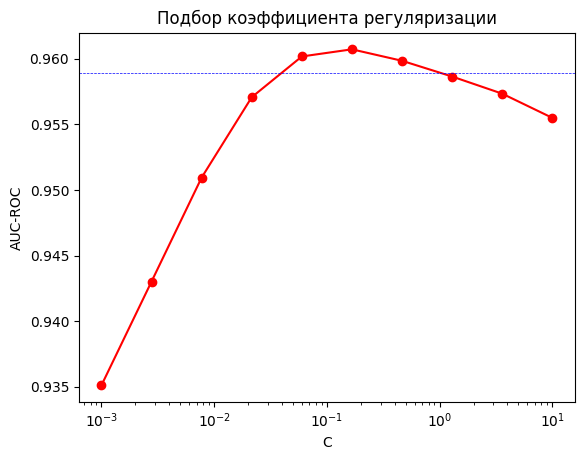

In [ ]:
plt.plot(Cs, scores, 'ro-')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('Подбор коэффициента регуляризации')
# горизонтальная линия -- качество модели с коэффициентом по умолчанию
plt.axhline(y=score_C_1, linewidth=.5, color = 'b', linestyle='dashed')
plt.show()

14.	Обучим модель со значением гипперпараметра C равным
0,1668101.


In [ ]:
# 0.16681005372 -> 0.961202396393
score_result = get_auc_lr_valid(X_train, y_train, C=0.1668101)
print(score_result)

0.9607206842456125


15.	В заключении обучим модель с найденным оптимальным значением коэффициента регуляризации.

In [ ]:
# подготовим данные для обучения и теста
tmp_scaled = StandardScaler().fit_transform(
    full_new_feat[['start_month', 'start_hour', 'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:],
                             tmp_scaled[:idx_split,:]]))
x_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:],
                            tmp_scaled[idx_split:,:]]))
# обучим модель на всей выборке с оптимальным коэффициентом регуляризации
lr = LogisticRegression(C=C, random_state=17).fit(X_train, y_train)
# сделаем прогноз для тестовой выборки
y_test = lr.predict_proba(X_test)[:, 1]
# запишем его в файл, готовый для сабмита
write_to_submission_file(y_test, "baseline_res.csv")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ValueError: X has 41601 features, but LogisticRegression is expecting 41604 features as input.

16.	Выполните индивидуальное задание.

Важные замечания
1.	При выборе набора данных (data set) на ресурсах [3, 4] необходимо согласовать свой выбор с другими студентами группы и преподавателем с целью недопустимости выбора одинаковых вариантов.
2.	В рамках данного лабораторного курса рекомендуется использовать инструментарий Python (библиотеки, среду разработки) для решения поставленных задач.

Индивидуальное задание
1.	Студент самостоятельно выбирает набор данных на ресурсах [3, 4] для построения классификатора с использованием метода логистической регрессии и согласует свой выбор с преподавателем.
2.	Выполните построение модели логистической регрессии. В ходе решения задачи необходимо решить следующие подзадачи:
2.1	В рамках выполнения задания необходимо ввести 2 новых синтезированных признака, оценить изменение точности модели после добавления признаков (с применением масштабирования признаков и без).
2.2	После определения необходимого набора признаков необходимо сформировать набор значений гипперпараметра модели и выбрать оптимальное значение. Постройте график (AUC-ROC, гипперпараметр C).
2.3	После обучения модели необходимо сохранить на диск значения бейслайн.

Содержание отчета и его форма

Отчет по лабораторной работе должен содержать:
1.	Номер и название лабораторной работы; задачи лабораторной работы.
2.	Реализация каждого пункта подраздела «Индивидуальное задание» с приведением исходного кода программы, диаграмм и графиков для визуализации данных.
3.	Ответы на контрольные вопросы.
4.	Экранные формы (консольный вывод) и листинг программного кода с комментариями, показывающие порядок выполнения лабораторной работы, и результаты, полученные в ходе её выполнения.
Отчет о выполнении лабораторной работы сдается преподавателю.

Контрольные вопросы
1.	За какие года представлены данные в обучающей и тестовой выборках? Ответ нужно аргументировать кодом на Python.
2.	Исследуйте с использованием Python исходный набор данных и дайте ответ на следующий вопрос: какие сайты чаще всего посещает Элис? Для ответа на вопрос можно доработать код пункта 4 учебного задания.
3.	На языке Python реализуйте проверку следующих утверждений:
–	Сессия Элис в среднем короче, чем сессия остальных пользователей.
–	Доля сессий Элис в выборке превышает 1%.
–	Диапазоны длительности сессий Элис и остальных пользователей примерно одинаковы.
–	Доля сессий Элис длительностью 40 с и более составляет менее четверти.
4. В рамках подпункта 9 учебной задачи постройте график зависимости количества сессий Элис от синтезированного признака start_month. Проверьте следующие утверждения:
–	с начала 2013 года по середину 2014 года количество ежемесячных сессий уменьшилось;
–	в целом количество сессий Элис за месяц постоянно на протяжении всего периода;
–	с начала 2013 года по середину 2014 года количество ежемесячных сессий возросло.
5.	Какие методы классификации являются линейными? Укажите основные параметры линеймой модели классификации. Что такое гипперпараметры линейной модели?
6.	Поясните назначение и принципы реализации методов стахостического градиента.
7.	Что такое «линейно разделимая выборка»?

Список литературы

Для выполнения лабораторной работы, при подготовке к защите, а также для ответа на контрольные вопросы рекомендуется использовать следующие источники: [1–5].


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Загрузка данных
data = pd.read_csv('1.benign.csv')

# Предполагаем, что последний столбец - это целевая переменная
X = data.drop(columns=data.columns[-1])
y = data.iloc[:, -1]

# Пример преобразования целевой переменной в бинарную классификацию
threshold = 0.5  # Пример порогового значения
y_binary = (y > threshold).astype(int)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)



In [13]:
# Создание синтезированных признаков
X_train['mean_all'] = X_train.mean(axis=1)
X_train['std_all'] = X_train.std(axis=1)

X_test['mean_all'] = X_test.mean(axis=1)
X_test['std_all'] = X_test.std(axis=1)


In [14]:
# Логистическая регрессия без масштабирования
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
auc_roc_without_scaling = roc_auc_score(y_test, y_pred)
print(f'ROC AUC без масштабирования: {auc_roc_without_scaling:.4f}')


ROC AUC без масштабирования: 0.8199


In [15]:
# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Логистическая регрессия с масштабированием
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)
y_pred = model.predict_proba(X_test_scaled)[:, 1]
auc_roc_with_scaling = roc_auc_score(y_test, y_pred)
print(f'ROC AUC с масштабированием: {auc_roc_with_scaling:.4f}')


ROC AUC с масштабированием: 1.0000


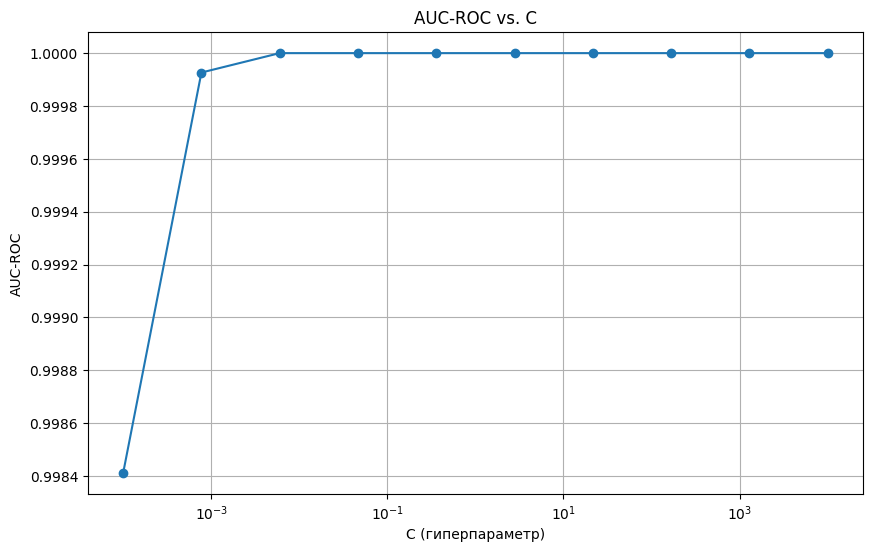

In [16]:
# Оптимизация гиперпараметра C
c_values = np.logspace(-4, 4, 10)
auc_roc_scores = []

for c in c_values:
    model = LogisticRegression(C=c, max_iter=1000)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict_proba(X_test_scaled)[:, 1]
    auc_roc = roc_auc_score(y_test, y_pred)
    auc_roc_scores.append(auc_roc)

# Построение графика AUC-ROC vs. C
plt.figure(figsize=(10, 6))
plt.plot(c_values, auc_roc_scores, marker='o')
plt.xscale('log')
plt.xlabel('C (гиперпараметр)')
plt.ylabel('AUC-ROC')
plt.title('AUC-ROC vs. C')
plt.grid(True)
plt.show()


In [17]:
import joblib

# Сохранение модели без масштабирования
joblib.dump(model, 'baseline_model_without_scaling.pkl')

# Сохранение модели с масштабированием
joblib.dump(model, 'baseline_model_with_scaling.pkl')


['baseline_model_with_scaling.pkl']